# Essai application modèle Lasso

## Principe :

En adoptant le principe d'une fonction objectif pénalisée, le LASSO permet de fixer un certain nombre de coefficients à 0. Les variables dont la norme est non nulle passent ainsi le test de sélection. 

Le LASSO est un programme d'optimisation sous contrainte. On cherche à trouver l'estimateur $\beta$ qui minimise l'erreur quadratique (régression linéaire) sous une contrainte additionnelle régularisant les paramètres:
$$
\min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) \\
\text{s.c. } \sum_{j=1}^p |\beta_j| \leq t
$$
Ce programme se reformule grâce au Lagrangien est permet ainsi d'obtenir un programme de minimisation plus maniable: 
$$
\beta^{\text{LASSO}} = \arg \min_{\beta} \bigg\{ \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) + \alpha \sum_{j=1}^p |\beta_j| \bigg\} = \arg \min_{\beta} \big\{ ||y-X\beta||_{2}^{2} + \alpha ||\beta||_1 \big\}
$$
où $\lambda$ est une réécriture de la régularisation précédente. 

## warning: sélection de variables corrélées


In [113]:
import numpy as np
import pandas as pd
import geopandas as gpd

df = gpd.read_file("donnees_augmentees.geojson")

In [114]:
df.head(3)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,distance_centre_paris,superficie_quartier,score_metro,geometry
0,Saint-Fargeau,78,23.1,16.17,27.72,Avant 1946,meublé,3,4.643464,1.486971,0.186527,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ..."
1,Villette,73,16.4,11.48,19.68,Apres 1990,non meublé,4,4.249599,1.285705,0.468929,"POLYGON ((2.37050 48.87820, 2.37028 48.87799, ..."
2,Belleville,77,21.6,15.12,25.92,1946-1970,non meublé,4,3.485188,0.806569,0.038651,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."


## Preprocessing

Les variables doivent toutes être numériques et standardisées 

### Variables numériques :

- On commence par supprimer les variables inutiles pour la régression linéaire : `min`, `max`et `geometry` :

In [115]:
df.drop(['min','max','geometry'],axis=1,inplace=True)

- La variable `meuble_txt` peut facilement étre convertie en une variable binaire `meuble_bin`. Comme on n'a que deux modalités, on peut utiliser `LabelEncoder` :

In [116]:
from sklearn.preprocessing import LabelEncoder

df['meuble_bin'] = LabelEncoder().fit_transform(df['meuble_txt'])
df.drop('meuble_txt',axis=1,inplace=True)

In [117]:
df.head(3)

,nom_quartier,id_quartier,ref,epoque,piece,distance_centre_paris,superficie_quartier,score_metro,meuble_bin
0,Saint-Fargeau,78,23.1,Avant 1946,3,4.643464,1.486971,0.186527,0
1,Villette,73,16.4,Apres 1990,4,4.249599,1.285705,0.468929,1
2,Belleville,77,21.6,1946-1970,4,3.485188,0.806569,0.038651,1


$\hookrightarrow$ `meuble_bin` vaut donc ici 0 si l'appartement est meublé, et 1 sinon.

- Pour la variable `id_quartier`, il y a 80 modalités. On peut donc, si on veut prendre en compte cette variable, utiliser `OneHotEncoder`. On va alors créer 80 nouvelles variables, et il faudra enlever l'une d'elle (peu importe laquelle) pour ne pas avoir de problème de colinéarité lorsqu'on réalisera des régressions linéaires.

In [119]:
from sklearn.preprocessing import LabelBinarizer

ohe_id_quartier = pd.DataFrame(LabelBinarizer().fit_transform(df['id_quartier'].sort_values()))

# On renomme les colonnes sous la forme : q_[0-79]
colonnes = {}
for i in range(80) :
    colonnes[i] = 'q_'+str(i+1)
ohe_id_quartier.rename(columns=colonnes, inplace=True)

In [120]:
# On ajoute les nouvelles variables et supprime celles devenues inutiles ('nom_quartier','id_quartier' et 'q_80')

df = df.join(ohe_id_quartier)
df.drop(['nom_quartier','id_quartier','q_80'],axis=1,inplace=True)

$\hookrightarrow$ Chaque variable `q_i` vaut 1 si l'appartement est situé dans le quartier numéro i, et 0 sinon.

- On fait pareil que précédemment pour la variable `epoque`. Cette fois, on a 4 modalités différentes (epoque_0 : 'Avant 1946' , epoque_1 : '1946-1970', epoque_2 : '1971-1990' et epoque_3 : 'Apres 1990').

In [122]:
ohe_epoque = pd.DataFrame(LabelBinarizer().fit_transform(df['epoque']))

# On renomme les colonnes sous la forme : epoque_[0-79]
colonnes = {0 : 'epoque_0', 1 : 'epoque_3', 2 : 'epoque_1', 3 : 'epoque_2'}  #faire df.head() pour comprendre quelle colonne correspond à quelle période de temps
ohe_epoque.rename(columns=colonnes, inplace=True)

In [123]:
# On ajoute les nouvelles variables et supprime celles devenues inutiles ('epoque' et 'epoque_0')

df = df.join(ohe_epoque)
df.drop(['epoque','epoque_0'],axis=1,inplace=True)

$\hookrightarrow$ Chaque variable `epoque_i` vaut 1 si l'appartement se trouve dans un immeuble datant de l'époque epoque_i. 

### Standardisation : 

Pour appliquer un modèle LASSO, il faut que toutes les variables numériques soient standardisées.

In [124]:
from sklearn.preprocessing import StandardScaler

data = StandardScaler().fit(df).transform(df.fillna(0))

## Choix de la valeur de l'hyperparamètre 

On va tester le modèle LASSO avec différentes valeurs pour l'hyper-paramètre $\alpha$, et représenter le nombre de variables sélectionnées en fonction de $\alpha$.

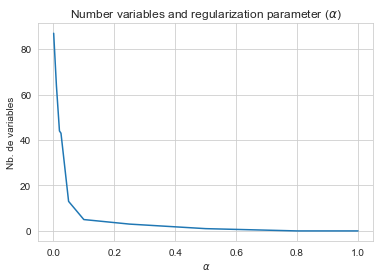

In [125]:
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import seaborn as sns

yindex = df.columns.get_loc("ref")
alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])

alpha_for_path, coefs_lasso, _ = lasso_path(np.delete(data, yindex, axis = 1),data[:,yindex],alphas=alphas)
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)

sns.set_style("whitegrid")
p = sns.lineplot(y=nb_non_zero, x=alpha_for_path).set(title = r"Number variables and regularization parameter ($\alpha$)", xlabel=r'$\alpha$', ylabel='Nb. de variables')
p
plt.show()

$\hookrightarrow$ On remarque que le nombre de variables sélectionnées décroit très rapidement. On peut supposer que cela est du au fait que si on établit que le quartier n'a pas d'influence sur le loyer, on peut directement écarter 79 variables...

## Modèle Lasso avec $\alpha=0.1$ 

Au vu du graphique précédent, on peut penser que la meilleur valeur de l'hyperparamètre soit $\alpha = 0.1$, zone d'inflexion de la courbe. On va donc tester le modèle LASSO avec ce paramètre pour voir quelles variables sont retenues pour expliquer le loyer des appartements.

In [126]:
from sklearn.linear_model import Lasso

alpha = 0.1

lasso1 = Lasso(fit_intercept=False,normalize=False, alpha = alpha)
lasso1.fit(np.delete(data, yindex, axis = 1),data[:,yindex])

Lasso(alpha=0.1, fit_intercept=False)

In [127]:
np.abs(lasso1.coef_)

array([0.4480399 , 0.18119295, 0.        , 0.        , 0.27604745,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Voici donc les colonnes sélectionnées par le modèle LASSO :

In [128]:
df.drop("ref", axis = 1).columns[np.abs(lasso1.coef_)>0]

Index(['piece', 'distance_centre_paris', 'meuble_bin', 'epoque_1', 'epoque_2'], dtype='object')

$\hookrightarrow$ Le modèle LASSO avec $\alpha = 0.1$ sélectionne donc le nombre de pièces comme ayant la plus grande incidence sur le loyer. Il sélectionne également la distance au centre de Paris, qui est une information sur les quartiers, et le fait que le logement soit proposé comme meublé ou non. Deux des variables correspondant à l'époque de construction sont également sélectionnées, mais obtiennent des coefficients beaucoup plus petits. 